# Airline Market Share Prediction Analysis

##  Phân tích và Dự đoán Thị phần Hãng Hàng không Mỹ

**Mục tiêu:** Xây dựng mô hình dự đoán thị phần của các hãng hàng không lớn dựa trên dữ liệu lịch sử




In [117]:
import warnings
warnings.filterwarnings('ignore')

# PySpark - Import specific classes to avoid conflicts
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, expr
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import (
    RandomForestRegressor as SparkRandomForestRegressor, 
    GBTRegressor as SparkGBTRegressor
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from xgboost.spark import SparkXGBRegressor
from pyspark.sql.functions import corr, avg, stddev

# Data processing & ML
import pandas as pd
import numpy as np
from builtins import min as py_min, max as py_max, sum as py_sum


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Model interpretation
import shap

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Utilities
import kagglehub
from datetime import datetime
import json
import joblib



ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Initialize Spark Session with optimized configuration
spark = SparkSession.builder \
    .appName("Enhanced Airline Market Share Prediction") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("WARN")


##  1. Data Loading & Initial Exploration


In [ ]:
# Download dataset
path = kagglehub.dataset_download("bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024")

# Load data with optimized settings
df = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .option("quote", '"')
    .option("escape", '"')
    .option("multiLine", "true")
    .option("mode", "PERMISSIVE")
    .option("nullValue", "")
    .option("nanValue", "NaN")
    .option("emptyValue", "")
    .csv(f"{path}/*.csv")
)

print(f" Shape: {df.count():,} rows × {len(df.columns)} columns")


 Shape: 245,955 rows × 23 columns


In [ ]:
# Schema
df.printSchema()

root
 |-- tbl: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- citymarketid_1: integer (nullable = true)
 |-- citymarketid_2: integer (nullable = true)
 |-- city1: string (nullable = true)
 |-- city2: string (nullable = true)
 |-- airportid_1: integer (nullable = true)
 |-- airportid_2: integer (nullable = true)
 |-- airport_1: string (nullable = true)
 |-- airport_2: string (nullable = true)
 |-- nsmiles: integer (nullable = true)
 |-- passengers: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- carrier_lg: string (nullable = true)
 |-- large_ms: double (nullable = true)
 |-- fare_lg: double (nullable = true)
 |-- carrier_low: string (nullable = true)
 |-- lf_ms: double (nullable = true)
 |-- fare_low: double (nullable = true)
 |-- Geocoded_City1: string (nullable = true)
 |-- Geocoded_City2: string (nullable = true)
 |-- tbl1apk: string (nullable = true)



In [ ]:
# Sample data
df.show(5)

+-------+----+-------+--------------+--------------+--------------------+--------------------+-----------+-----------+---------+---------+-------+----------+------+----------+--------+-------+-----------+------+--------+--------------+--------------+--------------------+
|    tbl|Year|quarter|citymarketid_1|citymarketid_2|               city1|               city2|airportid_1|airportid_2|airport_1|airport_2|nsmiles|passengers|  fare|carrier_lg|large_ms|fare_lg|carrier_low| lf_ms|fare_low|Geocoded_City1|Geocoded_City2|             tbl1apk|
+-------+----+-------+--------------+--------------+--------------------+--------------------+-----------+-----------+---------+---------+-------+----------+------+----------+--------+-------+-----------+------+--------+--------------+--------------+--------------------+
|Table1a|2021|      3|         30135|         33195|Allentown/Bethleh...|Tampa, FL (Metrop...|      10135|      14112|      ABE|      PIE|    970|       180| 81.43|        G4|     1.0|

In [ ]:
# Data types summary
df.describe().show()

+-------+--------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+---------+---------+-----------------+------------------+-----------------+----------+------------------+------------------+-----------+-------------------+------------------+--------------------+--------------------+--------------------+
|summary|     tbl|              Year|           quarter|    citymarketid_1|    citymarketid_2|               city1|               city2|       airportid_1|       airportid_2|airport_1|airport_2|          nsmiles|        passengers|             fare|carrier_lg|          large_ms|           fare_lg|carrier_low|              lf_ms|          fare_low|      Geocoded_City1|      Geocoded_City2|             tbl1apk|
+-------+--------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+

        Column  Missing_Count  Missing_Percentage
Geocoded_City2          39206           15.940314
Geocoded_City1          39206           15.940314
      fare_low           1612            0.655404
         lf_ms           1612            0.655404
   carrier_low           1612            0.655404
       fare_lg           1540            0.626131
      large_ms           1540            0.626131
    carrier_lg           1540            0.626131
           tbl              0            0.000000
    passengers              0            0.000000
          fare              0            0.000000
       nsmiles              0            0.000000
          Year              0            0.000000
     airport_2              0            0.000000
     airport_1              0            0.000000
   airportid_2              0            0.000000
   airportid_1              0            0.000000
         city2              0            0.000000
         city1              0            0.000000


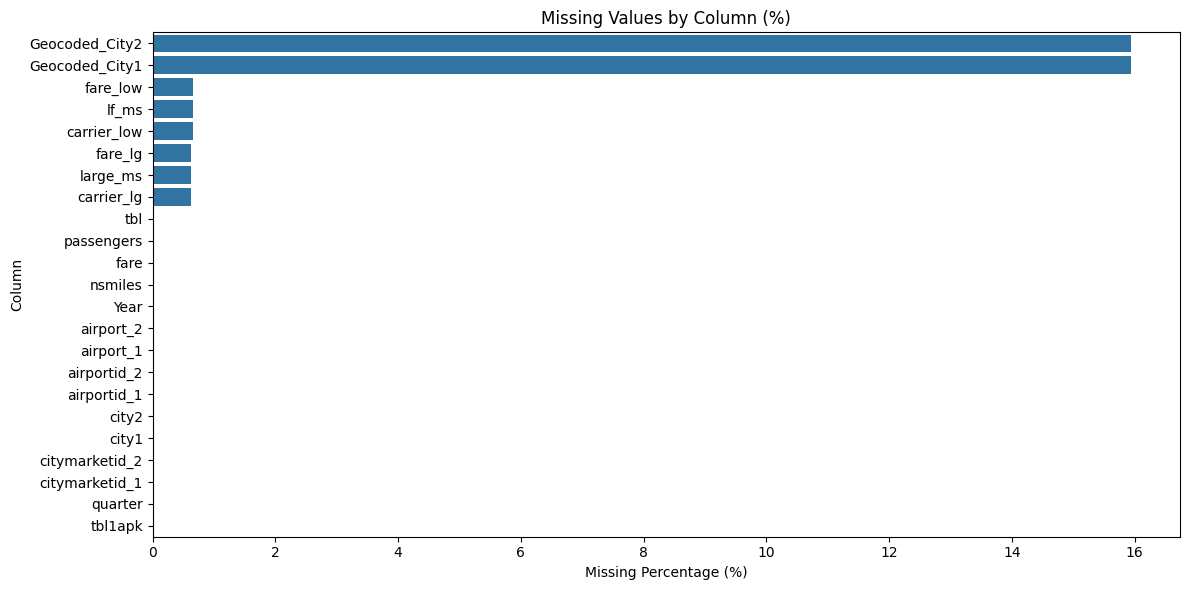

In [ ]:
# Missing values analysis
missing_data = df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns
]).collect()[0].asDict()

missing_df = pd.DataFrame(list(missing_data.items()), columns=['Column', 'Missing_Count'])
missing_df['Missing_Percentage'] = (missing_df['Missing_Count'] / df.count()) * 100
missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)

print(missing_df.to_string(index=False))

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.barplot(data=missing_df, x='Missing_Percentage', y='Column')
plt.title('Missing Values by Column (%)')
plt.xlabel('Missing Percentage (%)')
plt.tight_layout()
plt.show()


## 2. Data Cleaning & Preprocessing


In [ ]:
#Remove rows with null target variable
df_clean = df.filter(col('large_ms').isNotNull())
print(df_clean.count())

244415


In [ ]:
#Filter valid market share values (0-1)
df_clean = df_clean.filter((col('large_ms') >= 0) & (col('large_ms') <= 1))
print(df_clean.count())

244415


In [ ]:
#Remove invalid business metrics
df_clean = df_clean.filter(
    (col('passengers') > 0) & 
    (col('fare') > 0) & 
    (col('nsmiles') > 0)
)
print(df_clean.count())

238057


In [ ]:
#Remove rows with missing carrier information
df_clean = df_clean.dropna(subset=['carrier_low'])
print(df_clean.count())

237985


In [ ]:
#Remove extreme outliers (using IQR method)
numeric_cols = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms']
for col_name in numeric_cols:
    if col_name in df_clean.columns:
        # Calculate IQR
        quantiles = df_clean.select(
            expr(f"percentile_approx({col_name}, 0.25)").alias("q1"),
            expr(f"percentile_approx({col_name}, 0.75)").alias("q3")
        ).collect()[0]
        
        q1, q3 = quantiles['q1'], quantiles['q3']
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        df_clean = df_clean.filter(
            (col(col_name) >= lower_bound) & (col(col_name) <= upper_bound)
        )
print(df_clean.count())

211133


In [ ]:
df_clean.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c + "_nulls") for c in df_clean.columns
]).show()

+---------+----------+-------------+--------------------+--------------------+-----------+-----------+-----------------+-----------------+---------------+---------------+-------------+----------------+----------+----------------+--------------+-------------+-----------------+-----------+--------------+--------------------+--------------------+-------------+
|tbl_nulls|Year_nulls|quarter_nulls|citymarketid_1_nulls|citymarketid_2_nulls|city1_nulls|city2_nulls|airportid_1_nulls|airportid_2_nulls|airport_1_nulls|airport_2_nulls|nsmiles_nulls|passengers_nulls|fare_nulls|carrier_lg_nulls|large_ms_nulls|fare_lg_nulls|carrier_low_nulls|lf_ms_nulls|fare_low_nulls|Geocoded_City1_nulls|Geocoded_City2_nulls|tbl1apk_nulls|
+---------+----------+-------------+--------------------+--------------------+-----------+-----------+-----------------+-----------------+---------------+---------------+-------------+----------------+----------+----------------+--------------+-------------+-----------------+----

## 3. Exploratory Data Analysis (EDA)


In [ ]:

# Sample data for EDA
sample_size = 50000
df_sample = df_clean.sample(fraction=sample_size/df_clean.count(), seed=42).toPandas()

print(len(df_sample))

# Basic statistics
print(df_sample.describe().round(2))


50107
           Year   quarter  citymarketid_1  citymarketid_2  airportid_1  \
count  50107.00  50107.00        50107.00        50107.00     50107.00   
mean    2008.46      2.49        31563.83        32206.46     12443.02   
std        8.66      1.12         1105.95         1251.62      1432.50   
min     1993.00      1.00        30135.00        30189.00     10135.00   
25%     2001.00      1.00        30721.00        30994.00     11193.00   
50%     2008.00      2.00        31295.00        32337.00     12266.00   
75%     2016.00      3.00        32467.00        33195.00     13485.00   
max     2024.00      4.00        35412.00        35412.00     16440.00   

       airportid_2   nsmiles  passengers      fare  large_ms   fare_lg  \
count     50107.00  50107.00    50107.00  50107.00  50107.00  50107.00   
mean      13239.66   1189.68      173.93    216.27      0.67    215.71   
std        1431.13    697.69      196.95     67.25      0.23     72.11   
min       10466.00    109.00   

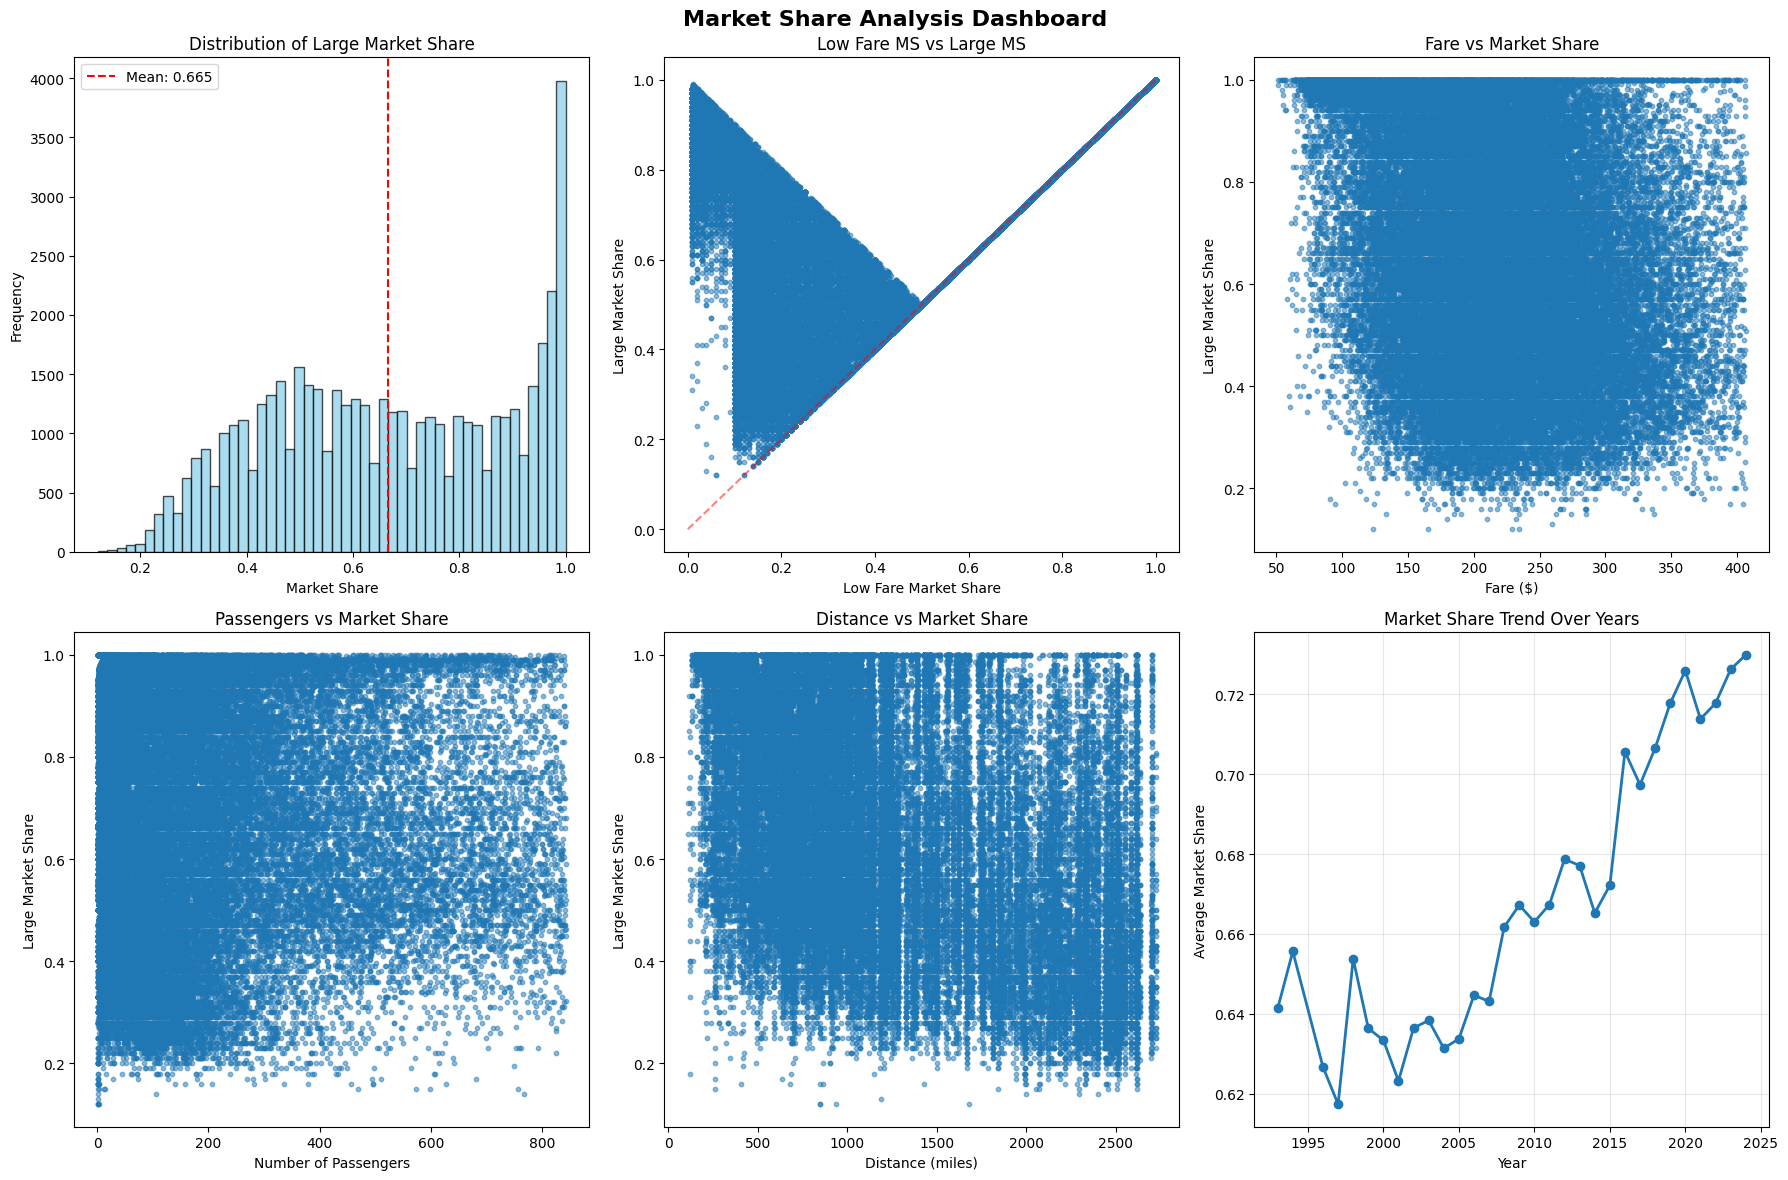

In [ ]:
# Market Share Distribution Analysis
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Market Share Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Market Share Distribution
axes[0,0].hist(df_sample['large_ms'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Large Market Share')
axes[0,0].set_xlabel('Market Share')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(df_sample['large_ms'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {df_sample["large_ms"].mean():.3f}')
axes[0,0].legend()

# 2. Low Fare Market Share vs Large Market Share
axes[0,1].scatter(df_sample['lf_ms'], df_sample['large_ms'], alpha=0.5, s=10)
axes[0,1].set_title('Low Fare MS vs Large MS')
axes[0,1].set_xlabel('Low Fare Market Share')
axes[0,1].set_ylabel('Large Market Share')
axes[0,1].plot([0, 1], [0, 1], 'r--', alpha=0.5)

# 3. Fare vs Market Share
axes[0,2].scatter(df_sample['fare'], df_sample['large_ms'], alpha=0.5, s=10)
axes[0,2].set_title('Fare vs Market Share')
axes[0,2].set_xlabel('Fare ($)')
axes[0,2].set_ylabel('Large Market Share')

# 4. Passengers vs Market Share
axes[1,0].scatter(df_sample['passengers'], df_sample['large_ms'], alpha=0.5, s=10)
axes[1,0].set_title('Passengers vs Market Share')
axes[1,0].set_xlabel('Number of Passengers')
axes[1,0].set_ylabel('Large Market Share')

# 5. Distance vs Market Share
axes[1,1].scatter(df_sample['nsmiles'], df_sample['large_ms'], alpha=0.5, s=10)
axes[1,1].set_title('Distance vs Market Share')
axes[1,1].set_xlabel('Distance (miles)')
axes[1,1].set_ylabel('Large Market Share')

# 6. Yearly Trend
yearly_avg = df_sample.groupby('Year')['large_ms'].mean()
axes[1,2].plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=6)
axes[1,2].set_title('Market Share Trend Over Years')
axes[1,2].set_xlabel('Year')
axes[1,2].set_ylabel('Average Market Share')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


TOP 10 CARRIERS BY AVERAGE MARKET SHARE:
            Route_Count  Avg_Market_Share  MS_StdDev  Total_Passengers  Avg_Fare
carrier_lg                                                                      
P9                   17             1.000      0.000              1845    88.163
E9                    2             1.000      0.000                39   103.850
U5                   30             0.917      0.185              4474   119.983
PN                    3             0.877      0.180                45   107.837
G4                  505             0.870      0.223             58789   116.296
WV                   12             0.857      0.181              1302   105.098
RL                    1             0.850        NaN               275   137.270
U2                    3             0.847      0.035               207   100.677
9N                    6             0.838      0.195               283   118.663
TZ                  272             0.818      0.239             684

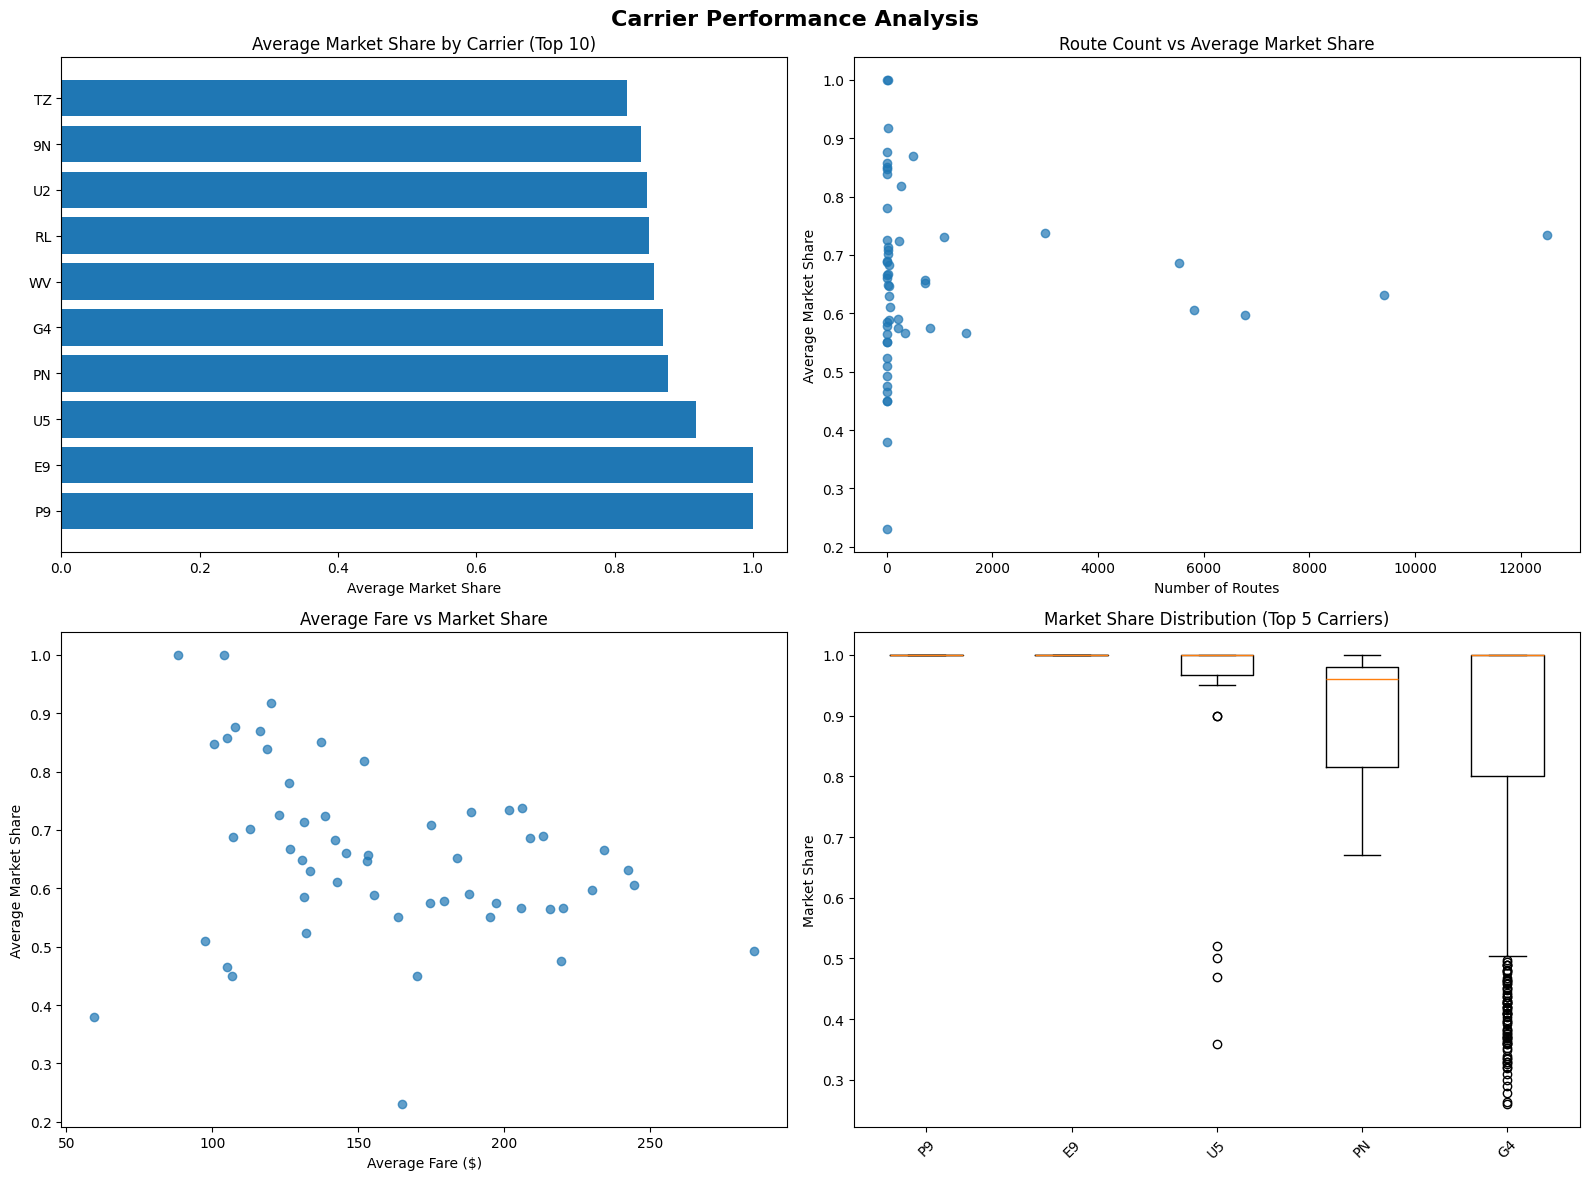

In [ ]:
# Carrier Analysis
# Top carriers by market share
carrier_stats = df_sample.groupby('carrier_lg').agg({
    'large_ms': ['count', 'mean', 'std'],
    'passengers': 'sum',
    'fare': 'mean'
}).round(3)

carrier_stats.columns = ['Route_Count', 'Avg_Market_Share', 'MS_StdDev', 'Total_Passengers', 'Avg_Fare']
carrier_stats = carrier_stats.sort_values('Avg_Market_Share', ascending=False)

print("TOP 10 CARRIERS BY AVERAGE MARKET SHARE:")
print(carrier_stats.head(10).to_string())

# Visualize carrier performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Carrier Performance Analysis', fontsize=16, fontweight='bold')

# 1. Market Share by Carrier (Top 10)
top_carriers = carrier_stats.head(10)
axes[0,0].barh(top_carriers.index, top_carriers['Avg_Market_Share'])
axes[0,0].set_title('Average Market Share by Carrier (Top 10)')
axes[0,0].set_xlabel('Average Market Share')

# 2. Route Count vs Market Share
axes[0,1].scatter(carrier_stats['Route_Count'], carrier_stats['Avg_Market_Share'], alpha=0.7)
axes[0,1].set_title('Route Count vs Average Market Share')
axes[0,1].set_xlabel('Number of Routes')
axes[0,1].set_ylabel('Average Market Share')

# 3. Fare vs Market Share
axes[1,0].scatter(carrier_stats['Avg_Fare'], carrier_stats['Avg_Market_Share'], alpha=0.7)
axes[1,0].set_title('Average Fare vs Market Share')
axes[1,0].set_xlabel('Average Fare ($)')
axes[1,0].set_ylabel('Average Market Share')

# 4. Market Share Distribution by Carrier
carrier_market_share = df_sample.groupby('carrier_lg')['large_ms'].apply(list)
top_5_carriers = carrier_stats.head(5).index
carrier_data = [carrier_market_share[carrier] for carrier in top_5_carriers]

axes[1,1].boxplot(carrier_data, labels=top_5_carriers)
axes[1,1].set_title('Market Share Distribution (Top 5 Carriers)')
axes[1,1].set_ylabel('Market Share')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 4. Advanced Feature Engineering


In [ ]:
# Create enhanced features
df_features = df_clean.withColumn(
    'revenue', F.col('passengers') * F.col('fare')
).withColumn(
    'fare_per_mile', F.col('fare') / F.col('nsmiles')
).withColumn(
    'fare_difference', F.col('fare') - F.col('fare_low')
).withColumn(
    'is_largest_cheapest', 
    F.when(F.col('carrier_lg') == F.col('carrier_low'), 1).otherwise(0)
).withColumn(
    'price_competitiveness', 
    F.when(F.col('fare') < F.col('fare_low') * 1.1, 1).otherwise(0)
).withColumn(
    'route_density', F.col('passengers') / F.col('nsmiles')
).withColumn(
    'is_peak_season', 
    F.when(F.col('quarter').isin([2, 3]), 1).otherwise(0)
).withColumn(
    'years_since_2000', F.col('Year') - 2000
).withColumn(
    'fare_elasticity', F.col('fare_difference') / F.col('fare_low')
).withColumn(
    'market_power', 
    F.when(F.col('large_ms') > 0.8, 'Dominant')
    .when(F.col('large_ms') > 0.5, 'Strong')
    .when(F.col('large_ms') > 0.2, 'Moderate')
    .otherwise('Weak')
).withColumn(
    'is_short_haul', F.when(F.col('nsmiles') < 500, 1).otherwise(0)
).withColumn(
    'is_medium_haul', F.when((F.col('nsmiles') >= 500) & (F.col('nsmiles') < 1500), 1).otherwise(0)
).withColumn(
    'is_long_haul', F.when(F.col('nsmiles') >= 1500, 1).otherwise(0)
).withColumn(
    'competition_level',
    F.when(F.col('lf_ms') > 0.8, 'High')
    .when(F.col('lf_ms') > 0.5, 'Medium')
    .otherwise('Low')
)

# Cache để tăng tốc
df_features = df_features.cache()

new_features = [
    'revenue', 'fare_per_mile', 'fare_difference', 'is_largest_cheapest',
    'price_competitiveness', 'route_density', 'is_peak_season', 'years_since_2000',
    'fare_elasticity', 'market_power', 'is_short_haul', 'is_medium_haul', 
    'is_long_haul', 'competition_level'
]

for feature in new_features:
    print(f"  • {feature}")

print(len(df_features.columns))
print(f"{df_features.count():,} rows × {len(df_features.columns)} columns")


  • revenue
  • fare_per_mile
  • fare_difference
  • is_largest_cheapest
  • price_competitiveness
  • route_density
  • is_peak_season
  • years_since_2000
  • fare_elasticity
  • market_power
  • is_short_haul
  • is_medium_haul
  • is_long_haul
  • competition_level
37
211,133 rows × 37 columns


In [ ]:
# Define feature columns
numeric_features = [
    'passengers', 'fare', 'nsmiles', 'lf_ms', 'fare_low', 'revenue', 
    'fare_per_mile', 'fare_difference', 'is_largest_cheapest', 'price_competitiveness',
    'route_density', 'is_peak_season', 'years_since_2000', 'fare_elasticity',
    'is_short_haul', 'is_medium_haul', 'is_long_haul', 'Year', 'quarter'
]

categorical_features = ['carrier_lg', 'carrier_low']

# Create string indexers for categorical features
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep")
    for col in categorical_features
]

# Feature vector assembly
feature_cols = numeric_features + [col+"_indexed" for col in categorical_features]
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

# Feature scaling
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Train-test split
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_data.count():,} rows")
print(f"Test set: {test_data.count():,} rows")
print(f"Features: {len(feature_cols)}")


Training set: 168,758 rows
Test set: 42,375 rows
Features: 21


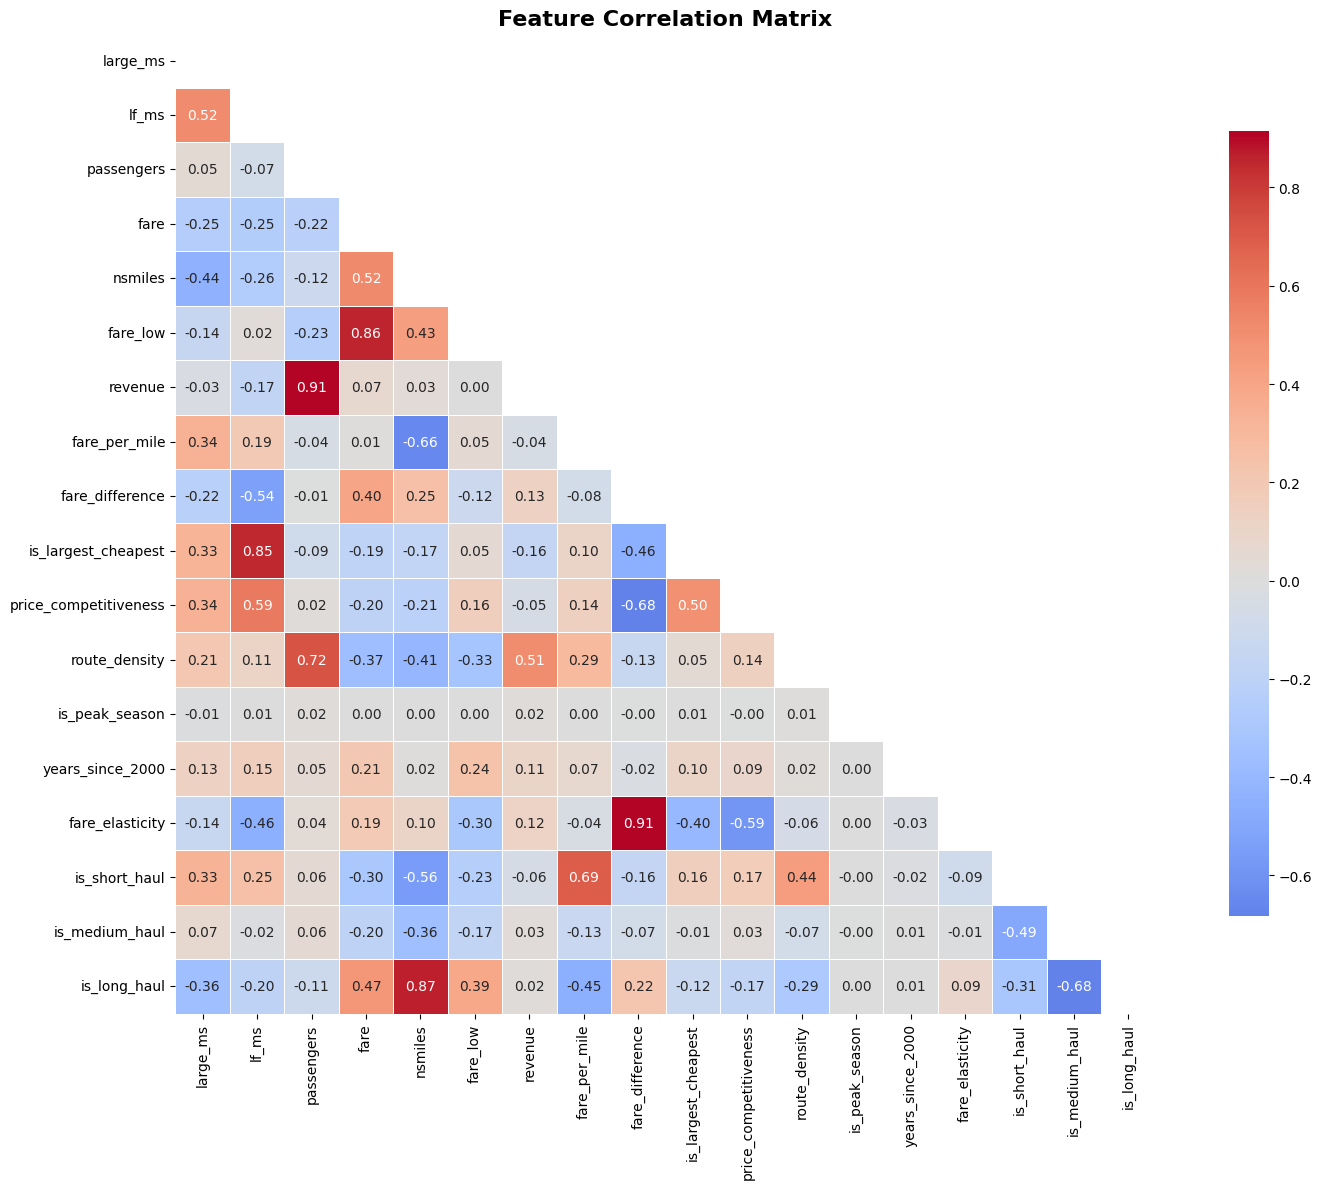

TOP CORRELATIONS WITH TARGET (large_ms):
  • lf_ms: 0.520
  • nsmiles: 0.439
  • is_long_haul: 0.359
  • price_competitiveness: 0.339
  • fare_per_mile: 0.339
  • is_short_haul: 0.333
  • is_largest_cheapest: 0.327
  • fare: 0.247
  • fare_difference: 0.224


In [ ]:
# Convert to Pandas for correlation analysis
df_corr = df_features.select([
    'large_ms', 'lf_ms', 'passengers', 'fare', 'nsmiles', 'fare_low',
    'revenue', 'fare_per_mile', 'fare_difference', 'is_largest_cheapest',
    'price_competitiveness', 'route_density', 'is_peak_season', 'years_since_2000',
    'fare_elasticity', 'is_short_haul', 'is_medium_haul', 'is_long_haul'
]).sample(fraction=0.1, seed=42).toPandas()

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Visualize correlation heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with target variable
target_correlations = correlation_matrix['large_ms'].abs().sort_values(ascending=False)
print("TOP CORRELATIONS WITH TARGET (large_ms):")
for feature, corr in target_correlations.head(10).items():
    if feature != 'large_ms':
        print(f"  • {feature}: {corr:.3f}")


##  5. Model Development & Training


In [ ]:
rf = SparkRandomForestRegressor(
    featuresCol="features",
    labelCol="large_ms",
    seed=42
)

#Hyperparameter grid for Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [10, 15, 20]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .addGrid(rf.subsamplingRate, [0.8, 1.0]) \
    .build()

# TrainValidationSplit for faster tuning
tvs_rf = TrainValidationSplit(
    estimator=Pipeline(stages=indexers + [assembler, scaler, rf]),
    estimatorParamMaps=paramGrid_rf,
    evaluator=RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8,
    parallelism=2,
    seed=42
)


tvs_model_rf = tvs_rf.fit(train_data)
# Get best parameters
best_rf_model = tvs_model_rf.bestModel.stages[-1]

print("BEST RANDOM FOREST PARAMETERS:")
print(f"  • numTrees: {best_rf_model.getNumTrees}")
print(f"  • maxDepth: {best_rf_model.getMaxDepth()}")
print(f"  • minInstancesPerNode: {best_rf_model.getMinInstancesPerNode()}")
print(f"  • maxBins: {best_rf_model.getMaxBins()}")
print(f"  • subsamplingRate: {best_rf_model.getSubsamplingRate()}")

In [ ]:
# Evaluate on test set
predictions_rf = tvs_model_rf.transform(test_data)
evaluator_rmse = RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="mae")

rf_rmse = evaluator_rmse.evaluate(predictions_rf)
rf_r2 = evaluator_r2.evaluate(predictions_rf)
rf_mae = evaluator_mae.evaluate(predictions_rf)

print(f"  • RMSE: {rf_rmse:.4f}")
print(f"  • R²: {rf_r2:.4f}")
print(f"  • MAE: {rf_mae:.4f}")


  • RMSE: 0.0740
  • R²: 0.8928
  • MAE: 0.0462


In [ ]:
gbt = SparkGBTRegressor(
    featuresCol="features",
    labelCol="large_ms",
    seed=42
)
# Hyperparameter grid for GBT
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [100, 150, 200]) \
    .addGrid(gbt.maxDepth, [5, 7, 10]) \
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.15]) \
    .addGrid(gbt.subsamplingRate, [0.8, 1.0]) \
    .build()

# TrainValidationSplit for GBT
tvs_gbt = TrainValidationSplit(
    estimator=Pipeline(stages=indexers + [assembler, scaler, gbt]),
    estimatorParamMaps=paramGrid_gbt,
    evaluator=RegressionEvaluator(labelCol="large_ms", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8,
    parallelism=2,
    seed=42
)

tvs_model_gbt = tvs_gbt.fit(train_data)

# Get best parameters
best_gbt_model = tvs_model_gbt.bestModel.stages[-1]
print(f"BEST GBT PARAMETERS:")
print(f"  • maxIter: {best_gbt_model.getMaxIter()}")
print(f"  • maxDepth: {best_gbt_model.getMaxDepth()}")
print(f"  • stepSize: {best_gbt_model.getStepSize()}")
print(f"  • subsamplingRate: {best_gbt_model.getSubsamplingRate()}")


Py4JJavaError: An error occurred while calling o76969.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task serialization failed: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:842)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:842)
         
java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:842)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:842)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1654)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler.submitMissingTasks(DAGScheduler.scala:1611)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1408)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$submitStage$5(DAGScheduler.scala:1411)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$submitStage$5$adapted(DAGScheduler.scala:1410)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1410)
	at org.apache.spark.scheduler.DAGScheduler.handleJobSubmitted(DAGScheduler.scala:1343)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3045)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3036)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3025)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)

	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2898)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2834)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2833)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2833)
	at org.apache.spark.scheduler.DAGScheduler.submitMissingTasks(DAGScheduler.scala:1621)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1408)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$submitStage$5(DAGScheduler.scala:1411)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$submitStage$5$adapted(DAGScheduler.scala:1410)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1410)
	at org.apache.spark.scheduler.DAGScheduler.handleJobSubmitted(DAGScheduler.scala:1343)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3045)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3036)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3025)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:995)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:436)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:56)
	at org.apache.spark.ml.regression.GBTRegressor.$anonfun$train$1(GBTRegressor.scala:190)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.GBTRegressor.train(GBTRegressor.scala:167)
	at org.apache.spark.ml.regression.GBTRegressor.train(GBTRegressor.scala:57)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:842)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:842)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1654)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler.submitMissingTasks(DAGScheduler.scala:1611)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1408)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$submitStage$5(DAGScheduler.scala:1411)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$submitStage$5$adapted(DAGScheduler.scala:1410)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.scheduler.DAGScheduler.submitStage(DAGScheduler.scala:1410)
	at org.apache.spark.scheduler.DAGScheduler.handleJobSubmitted(DAGScheduler.scala:1343)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3045)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3036)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3025)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\py4j\clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:ro

In [ ]:
# Evaluate on test set
predictions_gbt = tvs_model_gbt.transform(test_data)

gbt_rmse = evaluator_rmse.evaluate(predictions_gbt)
gbt_r2 = evaluator_r2.evaluate(predictions_gbt)
gbt_mae = evaluator_mae.evaluate(predictions_gbt)

print("GRADIENT BOOSTED TREES PERFORMANCE:")
print(f"  • RMSE: {gbt_rmse:.4f}")
print(f"  • R²: {gbt_r2:.4f}")
print(f"  • MAE: {gbt_mae:.4f}")

In [ ]:
import pyspark
import xgboost

print(f"PySpark version: {pyspark.__version__}")
print(f"XGBoost version: {xgboost.__version__}")

PySpark version: 3.5.0
XGBoost version: 2.1.4


In [ ]:
# Model 3: XGBoost with Hyperparameter Tuning using CrossValidator
# Apply the indexers to get the indexed columns
# Apply indexers to get indexed data
indexed_train = train_data
indexed_test = test_data

for indexer in indexers:
    indexer_model = indexer.fit(indexed_train)
    indexed_train = indexer_model.transform(indexed_train)
    indexed_test = indexer_model.transform(indexed_test)

# Assemble features into a vector
# Get all feature columns (including indexed ones)
all_feature_cols = [col for col in feature_cols if not col.endswith('_indexed')] + \
                   [col for col in indexed_train.columns if col.endswith('_indexed')]

assembler = VectorAssembler(
    inputCols=all_feature_cols,
    outputCol="features",
    handleInvalid="keep"
)

train_assembled = assembler.transform(indexed_train)
test_assembled = assembler.transform(indexed_test)

In [ ]:
xgb_spark = SparkXGBRegressor(
    features_col="features",
    label_col="large_ms",
    prediction_col="prediction",
    num_workers=2,
    seed=42,
    tree_method='hist',
    eval_metric='rmse'
)

# Setup evaluator (define BEFORE using in CrossValidator)
evaluator = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="rmse"
)

# Define Parameter Grid for tuning
param_grid = (
    ParamGridBuilder()
    .addGrid(xgb_spark.max_depth, [4, 6, 8])
    .addGrid(xgb_spark.learning_rate, [0.05, 0.1, 0.2])
    .addGrid(xgb_spark.n_estimators, [100, 200])
    .addGrid(xgb_spark.subsample, [0.7, 0.9])
    .addGrid(xgb_spark.colsample_bytree, [0.7, 0.9])
    .build()
)

total_combinations = len(param_grid)
print(total_combinations)

In [ ]:
# Setup Cross Validator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
crossval = CrossValidator(
    estimator=xgb_spark,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,  # 3-fold cross validation
    parallelism=2,  # Number of parallel models to train
    seed=42
)

try:
    cv_model = crossval.fit(train_assembled)
except Exception as e:
    raise

# Get the best model
xgb_model = cv_model.bestModel

In [ ]:
# Display best parameters
print(" BEST HYPERPARAMETERS:")
best_params = cv_model.bestModel.extractParamMap()
for param, value in best_params.items():
    if param.name in ['max_depth', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree']:
        print(f"  • {param.name}: {value}")

In [ ]:
# Display CV metrics
print("CROSS-VALIDATION RESULTS:")
avg_metrics = cv_model.avgMetrics

print(f"  • Best CV RMSE: {py_min(avg_metrics):.4f}")
print(f"  • Worst CV RMSE: {py_max(avg_metrics):.4f}")
print(f"  • Mean CV RMSE: {py_sum(avg_metrics)/len(avg_metrics):.4f}")

In [ ]:
# Show top 5 parameter combinations
print("TOP 5 PARAMETER COMBINATIONS:")
sorted_indices = sorted(range(len(avg_metrics)), key=lambda i: avg_metrics[i])
for rank, idx in enumerate(sorted_indices[:5], 1):
    params_map = param_grid[idx]
    print(f"\n  Rank {rank} - CV RMSE: {avg_metrics[idx]:.4f}")
    for param, value in params_map.items():
        if param.name in ['max_depth', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree']:
            print(f"    • {param.name}: {value}")

In [ ]:
# Make predictions
train_predictions = xgb_model.transform(train_assembled)
test_predictions = xgb_model.transform(test_assembled)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="r2"
)

evaluator_mae = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="mae"
)

# Calculate metrics on test set
test_rmse = evaluator_rmse.evaluate(test_predictions)
test_r2 = evaluator_r2.evaluate(test_predictions)
test_mae = evaluator_mae.evaluate(test_predictions)

# Calculate metrics on training set
train_rmse = evaluator_rmse.evaluate(train_predictions)
train_r2 = evaluator_r2.evaluate(train_predictions)
train_mae = evaluator_mae.evaluate(train_predictions)

In [ ]:
print("XGBOOST MODEL PERFORMANCE (WITH TUNED HYPERPARAMETERS):")
print(f" Training Set:")
print(f"  • RMSE: {train_rmse:.4f}")
print(f"  • R²: {train_r2:.4f}")
print(f"  • MAE: {train_mae:.4f}")

print(f" Test Set:")
print(f"  • RMSE: {test_rmse:.4f}")
print(f"  • R²: {test_r2:.4f}")
print(f"  • MAE: {test_mae:.4f}")

In [ ]:
# Feature importance
print("FEATURE IMPORTANCE:")
try:
    # Get feature importance from the underlying XGBoost model
    feature_importance = xgb_model.get_feature_importances()
    
    if feature_importance:
        feature_importance_df = pd.DataFrame({
            'feature': [all_feature_cols[int(k.replace('f', ''))] for k in feature_importance.keys()],
            'importance': list(feature_importance.values())
        }).sort_values('importance', ascending=False)
        
        print(f"\n  TOP 10 MOST IMPORTANT FEATURES:")
        for idx, row in feature_importance_df.head(10).iterrows():
            print(f"  • {row['feature']}: {row['importance']:.4f}")
    else:
        print("  • Feature importance not available")
except Exception as e:
    print(f"  • Could not extract feature importance: {str(e)}")
    
    # Alternative: Get feature scores from native XGBoost model
    try:
        native_model = xgb_model.get_booster()
        importance_dict = native_model.get_score(importance_type='gain')
        
        feature_importance_df = pd.DataFrame({
            'feature': [all_feature_cols[int(k.replace('f', ''))] for k in importance_dict.keys()],
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=False)
        
        print(f"\n  TOP 10 MOST IMPORTANT FEATURES (from booster):")
        for idx, row in feature_importance_df.head(10).iterrows():
            print(f"  • {row['feature']}: {row['importance']:.4f}")
    except Exception as e2:
        print(f"  • Alternative method also failed: {str(e2)}")

In [ ]:
# Sample predictions
test_predictions.select("large_ms", "prediction").show(10, truncate=False)

  • Total parameter combinations: 72
🔄 Setting up 72-combination grid search with 3-fold CV...
  • Training 72 models × 3 folds = 216 total fits


2025-10-23 22:03:40,405 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'colsample_bytree': 0.9, 'device': 'cpu', 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror', 'subsample': 0.7, 'tree_method': 'hist', 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-10-23 22:03:40,416 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'colsample_bytree': 0.7, 'device': 'cpu', 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror', 'subsample': 0.7, 'tree_method': 'hist', 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-10-23 22:03:46,548 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-10-23 22:03:47,018 INFO XGBoost-PySpark: _fit F


 BEST HYPERPARAMETERS:
  • colsample_bytree: 0.9
  • learning_rate: 0.2
  • max_depth: 8
  • n_estimators: 200
  • subsample: 0.9

 CROSS-VALIDATION RESULTS:
  • Best CV RMSE: 0.0666
  • Worst CV RMSE: 0.0850
  • Mean CV RMSE: 0.0744

  TOP 5 PARAMETER COMBINATIONS:

  Rank 1 - CV RMSE: 0.0666
    • max_depth: 8
    • learning_rate: 0.2
    • n_estimators: 200
    • subsample: 0.9
    • colsample_bytree: 0.9

  Rank 2 - CV RMSE: 0.0673
    • max_depth: 8
    • learning_rate: 0.2
    • n_estimators: 200
    • subsample: 0.9
    • colsample_bytree: 0.7

  Rank 3 - CV RMSE: 0.0677
    • max_depth: 8
    • learning_rate: 0.1
    • n_estimators: 200
    • subsample: 0.9
    • colsample_bytree: 0.9

  Rank 4 - CV RMSE: 0.0677
    • max_depth: 8
    • learning_rate: 0.2
    • n_estimators: 200
    • subsample: 0.7
    • colsample_bytree: 0.9

  Rank 5 - CV RMSE: 0.0681
    • max_depth: 8
    • learning_rate: 0.1
    • n_estimators: 200
    • subsample: 0.7
    • colsample_bytree: 0.9

 XGBOO

In [ ]:
# Calculate prediction statistics
prediction_stats = test_predictions.select(
    corr("large_ms", "prediction").alias("correlation"),
    avg("large_ms").alias("actual_mean"),
    avg("prediction").alias("predicted_mean"),
    stddev("large_ms").alias("actual_stddev"),
    stddev("prediction").alias("predicted_stddev")
).collect()[0]

print("PREDICTION STATISTICS:")
print(f"  • Correlation: {prediction_stats['correlation']:.4f}")
print(f"  • Actual mean: {prediction_stats['actual_mean']:.4f}")
print(f"  • Predicted mean: {prediction_stats['predicted_mean']:.4f}")
print(f"  • Actual std dev: {prediction_stats['actual_stddev']:.4f}")
print(f"  • Predicted std dev: {prediction_stats['predicted_stddev']:.4f}")
